NASA ocean color data with NetCDF and OpenDAP
-------
-------

This notebook demonstrates how to remotely access NASA satellite images via OpenDAP server, and work with the data in NetCDF format.

The main directory of NASA's OpenDAP server is located at http://oceandata.sci.gsfc.nasa.gov/opendap/ For the MODISA-Aqua satellite, daily level 3 mapped data is available through this server. The level 3 data has gone through the highest level of processing, including cloud masking, calculation of variables such as chlorophyll-a and sea surface temperature using standard algorithms, and mapping to a regular longitude-latitude grid.

### NetCDF dataset structure

The xarray package (http://xarray.pydata.org) is used here to open the dataset. The structure of datasets in xarray is based on the NetCDF data structure, so the package provides an intuitive high-level interface. The OpenDAP server allows us to use the data without having to download the entire global data file for that day.

NASA organizes data by year and year day. The file used in this example contains the mapped chlorophyll-a data for May 7 (year day 127), 2015.

In [1]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt, ticker
from matplotlib.colors import LogNorm
from datetime import datetime
from mpl_toolkits.basemap import Basemap 
import xarray as xr

filename = 'http://oceandata.sci.gsfc.nasa.gov:80/opendap/MODISA/L3SMI/2015/127/A2015127.L3m_DAY_CHL_chlor_a_4km.nc'
data = xr.open_dataset(filename)
#print(data)

/Users/tomconnolly/programs/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


### Variables and attributes

The xarray dataset mirrors the original NetCDF data. It contains the same dimensions, variables and attributes. Because the NASA NetCDF files are CF compliant (see http://cfconventions.org/), xarray is able to identify longitude and latitude as coordinates. The variables also have attributes that contain useful metadata. The attributes of the dataset, and individual variables, can be easily accessed.

In [2]:
print(data['chlor_a'])

# print attributes (metadata)
print('')
print('examples of dataset attributes: time_coverage_start, time_coverage_end')
print(data.attrs['time_coverage_start'])
print(data.attrs['time_coverage_end'])
print('')
print('example of variable attributes: units')
print(data['chlor_a'].attrs['units'])

<xarray.DataArray 'chlor_a' (lat: 4320, lon: 8640)>
[37324800 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 89.98 89.94 89.9 89.85 89.81 89.77 89.73 89.69 ...
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.9 -179.8 -179.8 -179.7 ...
Attributes:
    long_name: Chlorophyll Concentration, OCI Algorithm
    units: mg m^-3
    standard_name: mass_concentration_chlorophyll_concentration_in_sea_water
    valid_min: 0.001
    valid_max: 100.0
    display_scale: log
    display_min: 0.01
    display_max: 20.0
    reference: Hu, C., Lee Z., and Franz, B.A. (2012). Chlorophyll-a algorithms for oligotrophic oceans: A novel approach based on three-band reflectance difference, J. Geophys. Res., 117, C01011, doi:10.1029/2011JC007395.

examples of dataset attributes: time_coverage_start, time_coverage_end
2015-05-06T23:50:09.000Z
2015-05-08T02:00:08.000Z

example of variable attributes: units
mg m^-3


### Extract subset of data

The OpenDAP data is convenient because it is not necessary to download the entire global data file. The following code extracts the data values, and coordinates, for a rectangular subset given the coordinates of the bounding box. Storing the data values in numpy arrays allows for easy manipulation with *numpy* and plotting with *pyplot*. This example is for the Central California coast.

In [3]:
# coordinates that define the subset to be extracted
lon_min = -126.
lon_max = -120.
lat_min = 35.
lat_max = 40.

# find indices of dataset in this box
lon_all = np.array(data['lon'])
lat_all = np.array(data['lat'])
loni, = np.where((lon_all > lon_min) & (lon_all < lon_max))
lati, = np.where((lat_all > lat_min) & (lat_all < lat_max))

# create variables for subset
lon = lon_all[loni]
lat = lat_all[lati]
LON,LAT = np.meshgrid(lon,lat)
chl_subset = np.array(data['chlor_a'][lati[0]:(lati[-1]+1),
                             loni[0]:(loni[-1]+1)])

# create masked array
chl_mask = np.ma.masked_invalid(chl_subset)

### Plotting

The chlorophyll-a data approximately follows an exponential distribution. There are a lot of small values and not many high values. Plotting the log-transformed data helps create a useful visualization to identify high-chlorophyll values.

<IPython.core.display.Javascript object>


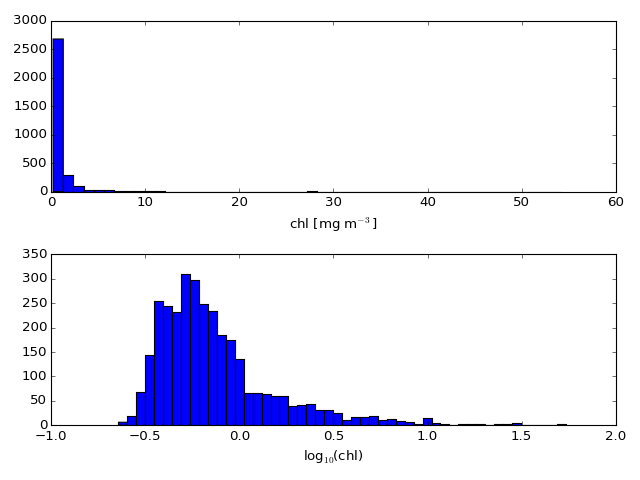

In [4]:
# create 1-D array with no NaNs for histogram
goodi = np.where(np.isfinite(chl_subset)) # indices of finite data values
chl_finite_1d = np.reshape(chl_subset[goodi],-1) # reshape 2d array to 1d

plt.figure()
plt.subplot(2,1,1)
hist1 = plt.hist(chl_finite_1d,bins=50)
plt.xlabel('chl [mg m$^{-3}$]')
plt.subplot(2,1,2)
hist2 = plt.hist(np.log10(chl_finite_1d),bins=50)
plt.xlabel('log$_{10}$(chl)')
plt.tight_layout()

<IPython.core.display.Javascript object>


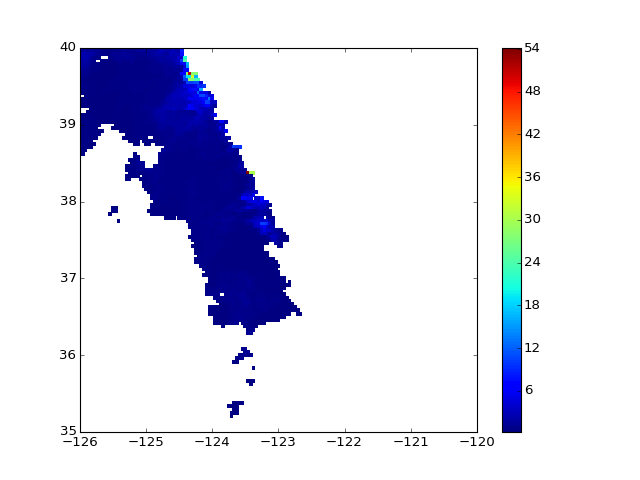

<IPython.core.display.Javascript object>


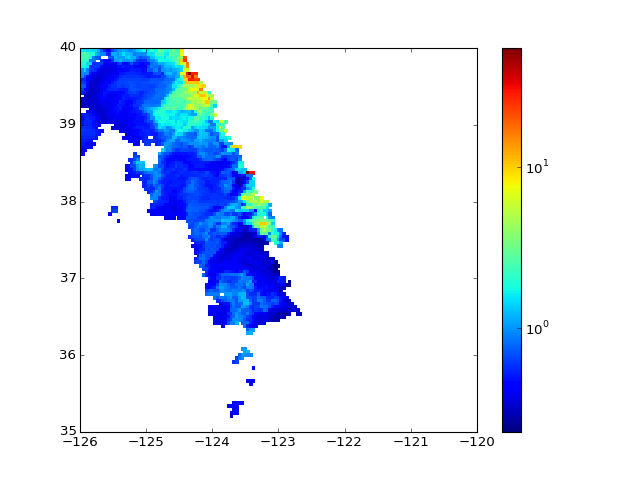

<matplotlib.colorbar.Colorbar instance at 0x113258950>

In [5]:
plt.figure()
plt.pcolor(lon,lat,chl_mask)
plt.colorbar()

plt.figure()
plt.pcolor(lon,lat,chl_mask,norm=LogNorm())
plt.colorbar()

### Mapping

Plotting this way as a function of longitude and latitude clearly distorts the aspect ratio. The Basemap package can be used to display the data using a map projection. A Lambert Conformal Conic projection is useful for maps at mid-latitudes. From the map, one can identify areas of calculated chlorophyll-a near the coast, and a lot of areas that are masked due to the presence of clouds.

<IPython.core.display.Javascript object>


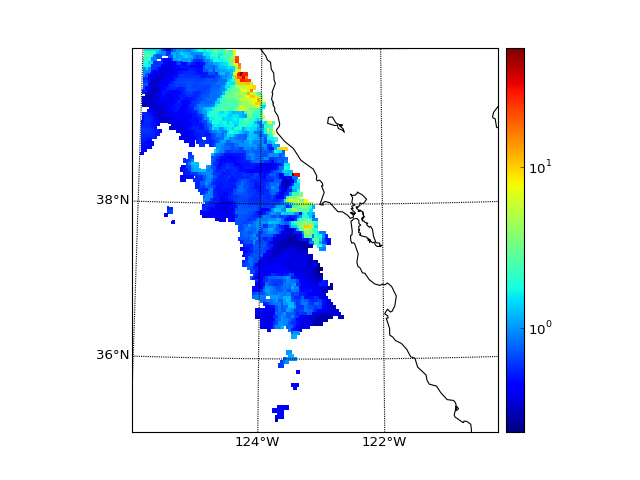

In [6]:
plt.figure()
m = Basemap(projection='lcc',llcrnrlat=np.min(lat), 
           urcrnrlat=np.max(lat), 
           llcrnrlon=np.min(lon), 
           urcrnrlon=np.max(lon), 
           lat_0=np.mean(lat),
           lon_0=np.mean(lon),
           resolution='i')

# make 2d arrays for longitude and latitude
LON,LAT = np.meshgrid(lon,lat)
mlon,mlat = m(LON,LAT)

m.pcolor(mlon,mlat,chl_mask,norm=LogNorm())
m.colorbar()
m.drawparallels(np.arange(32,50,2),labels=[True,False,False,False])
m.drawmeridians(np.arange(-126,-116,2),labels=[False,False,False,True])
m.drawcoastlines()

#### Work in progress: function to extract daily data for arbitrary variable and bounding box

In [12]:
from urllib2 import urlopen
import re

dtime = datetime(2015,5,7)
variable = 'chlor_a'

def extract_daily_subset(variable,dtime,lon_min,lon_max,lat_min,lat_max,res='4km',satellite='MODISA',product='L3SMI'):
    #
    #
    
    year = dtime.year
    yday = dtime.strftime('%j')
    
    data_dir = 'http://oceandata.sci.gsfc.nasa.gov:80/opendap/' \
                + satellite + '/' + product + '/' + str(year) + '/' + str(yday) + '/'
    
    urlpath = urlopen(data_dir)
    string = urlpath.read().decode()
    regexp = '"A*.nc'
    pattern = re.compile(regexp)
    filelist = pattern.findall(string)
    urlpath.close()
    #print(string)
    print(filelist)
    
    filename = 'http://oceandata.sci.gsfc.nasa.gov:80/opendap/MODISA/L3SMI/2015/127/A2015127.L3m_DAY_CHL_chlor_a_4km.nc'
    data = xr.open_dataset(filename)

    # find indices of dataset in this box
    lon_all = np.array(data['lon'])
    lat_all = np.array(data['lat'])
    loni, = np.where((lon_all > lon_min) & (lon_all < lon_max))
    lati, = np.where((lat_all > lat_min) & (lat_all < lat_max))

    # create variables for subset
    lon = lon_all[loni]
    lat = lat_all[lati]
    var_subset = data[variable][lati[0]:(lati[-1]+1),
                                 loni[0]:(loni[-1]+1)]
    
    return var_subset,lat,lon

data,lon,lat = extract_daily_subset(variable,dtime,lon_min,lon_max,lat_min,lat_max,res='4km')

[u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', u'"enc', 

### Exercises

* Write a function that returns the monthly average of a MODIS field, given the month, year, bounding coordinates and variable name. Display an example of the result on a map.
* Write a function that creates climatological average field, given the month, range of years, bounding coordinates and variable name. For the same area, time and variable as in the first exercise, plot the climatological average and the anomaly.